In [8]:
import numpy as np
import os
from collections import defaultdict
from nltk.stem import PorterStemmer
import math
import matplotlib.pyplot as plt

In [9]:
s = " a, about, an, are, as, at, be, by, for, from, how, in, is, of, on, or, that, the, these, this, too, was, what, when, where, who, will"
verbose = set([word for word in s.split(', ')])

In [26]:
def skip_verbose(words, verbose):
    i = 0
    while i < len(words):
        if words[i] in verbose:
            words.pop(i)
        else:
            i += 1
    return words

In [36]:
# uni gram 
# compute probability

def uni_generator(name, k=1, unkp=0.0005):    
    ps = PorterStemmer()

    # count word frequency
    count = defaultdict(int)
    f = open("./train/" + name + ".txt", "r")
    reviews = []
    for review in f:
        reviews.append(review)
        words = review.split(" ")
        
        # preprocess

        
        for word in words:
            word = ps.stem(word)
            count[word] += 1

    # least frequent words         
    unk_words = set(sorted(count.keys(), key=lambda x:count[x])[:int(unkp*len(count))])
    
  
    # redo counting
    total = 0
    count = defaultdict(int)
    
    for review in reviews:
        words = review.split(" ")
        
        # preprocess

        
        for word in words:
            word = ps.stem(word)
            if word in unk_words:
                count["<UNK>"] += 1
            else:
                count[word] += 1
            total += 1
            
    if count["<UNK>"] == 0:
        count["<UNK>"] += 1
    # probability with smooth 
    prob_uni = {word: (count[word]+k)/(total + k * len(count)) for word in count}
    return prob_uni

# perplexity
def uni_predict(words, prob_uni):
    ps = PorterStemmer()
    temp = 0
    for word in words:
        word = ps.stem(word)
        if word not in prob_uni:
            word = "<UNK>"
        temp -=math.log(prob_uni[word])
    return math.exp(temp/len(words))

In [37]:
# bi gram
# compute probability

def bi_generator(name, unkp=0.0005):
    ps = PorterStemmer()
    
    # least frequent words
    count_uni = defaultdict(int)
    f = open("./train/" + name + ".txt", "r")
    reviews = []
    for review in f:
        reviews.append(review)
        words = review.split(" ")
        for word in words:
            word = ps.stem(word)
            count_uni[word] += 1
        
    unk_uni = set(sorted(count_uni.keys(), key=lambda x:count_uni[x])[:int(unkp*len(count_uni))])
    
    # redo counting
    count_uni = defaultdict(int)
    count_bi = defaultdict(int)

    for review in reviews:      
        words = review.split(" ")
        
        # insert start symbol
        words = ["<S>"] + words
        i = 0
        while i < len(words)-1:
            if ps.stem(words[i]) in [".", "?", "!"]:
                words.insert(i+1, "<E>")
                words.insert(i+2, "<S>")
            i += 1
        words.append("<E>")
            
        # uni
        for word in words:
            word = ps.stem(word)
            if word in unk_uni:
                count_uni["<UNK>"] += 1
            else:
                count_uni[word] += 1       
        
        # bi
        # add start symbol
        for idx in range(len(words)-1):
            word1 = ps.stem(words[idx])
            word2 = ps.stem(words[idx+1])
            

            # add unk
            # smooth sceneria
            if word1 in unk_uni and word2 in unk_uni:
                count_bi["<UNK> <UNK>"] += 1
            elif word1 in unk_uni:
                count_bi["<UNK> " + word2] += 1
            elif word2 in unk_uni:
                count_bi[word1 + " <UNK>"] += 1
            else:
                combo = word1 + " " + word2
                count_bi[combo] += 1       
    return count_uni, count_bi   

# perplexity
def bi_predict(words, count_uni, count_bi, k=1):
    ps = PorterStemmer()
    
    
    # insert start symbol
    words = ["<S>"] + words
    i = 0
    while i < len(words):
        if ps.stem(words[i]) in [".", "?", "!"]:
            words.insert(i+1, "<E>")
            words.insert(i+2, "<S>")
        i += 1
    words.append("<E>")
        
    # calculate
    temp = 0
    for i in range(len(words)-1):
        word1 = ps.stem(words[i])
        word2 = ps.stem(words[i+1])
        
        # unk scenaria
        if word1 not in count_uni and word2 not in count_uni:
            combo = "<UNK> <UNK>"
        elif word1 not in count_uni:
            combo = "<UNK> " + word2
        elif word2 not in count_uni:
            combo = word1 + " <UNK>"
        else:
            combo = word1 + " " + word2
        if combo not in count_bi:
            combo = "<UNK> <UNK>"
        if word1 not in count_uni:
            word1 = "<UNK>"
        
        p = (count_bi[combo] + k)/(count_uni[word1] + k*len(count_uni))
        temp -=math.log(p)
    return math.exp(temp/len(words)-1)

In [38]:
# validation uni LM algo
def validation_uni(uni_generator, k, unkp):
    prob_uni_d = uni_generator("deceptive", k, unkp)
    prob_uni_t = uni_generator("truthful", k, unkp)
    
    classes = ["deceptive", "truthful"]
    num_corpus = 0
    correct_prediction = 0
    
    ans = []
    
    for label in classes:
        f = open("./validation/" +  label + ".txt", "r")
        num = 0
        correct = 0
        
        for review in f:
            num_corpus += 1
            num += 1
            
            words = review.split(" ")
            

            # uni-gram
            p_uni_d = uni_predict(words, prob_uni_d)
            p_uni_t = uni_predict(words, prob_uni_t)
            if p_uni_d < p_uni_t:
                if label == "deceptive":
                    correct_prediction += 1
                    correct += 1
                    
            else:
                if label == "truthful":
                    correct_prediction += 1
                    correct += 1
        ans.append(correct/num)
#         print(label + " category acc: " + str(correct/num))
    ans.append(correct_prediction/num_corpus)
#     print("Total acc: " + str(correct_prediction/num_corpus))
    return ans

In [39]:
# validation ubi LM algo
def validation_bi(bi_generator, k, unkp):
    count_uni_d, count_bi_d  = bi_generator("deceptive", unkp)
    count_uni_t, count_bi_t = bi_generator("truthful", unkp)
    
    classes = ["deceptive", "truthful"]
    num_corpus = 0
    correct_prediction = 0
    
    ans = []
    
    for label in classes:
        f = open("./validation/" +  label + ".txt", "r")
        num = 0
        correct = 0
        
        for review in f:
            num_corpus += 1
            num += 1
            
            words = review.split(" ")
            

            # bi-gram
            p_bi_d = bi_predict(words, count_uni_d, count_bi_d, k)
            p_bi_t = bi_predict(words, count_uni_t, count_bi_t, k)
            if p_bi_d < p_bi_t:
                if label == "deceptive":
                    correct_prediction += 1
                    correct += 1
                    
            else:
                if label == "truthful":
                    correct_prediction += 1
                    correct += 1
        ans.append(correct/num)
#         print(label + " category acc: " + str(correct/num))
    ans.append(correct_prediction/num_corpus)
#     print("Total acc: " + str(correct_prediction/num_corpus))
    return ans

In [16]:
# uni LM parameter selection

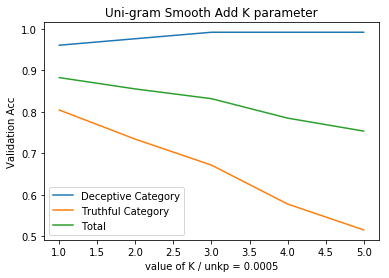

In [159]:
record = []
for k in range(1, 6):
    record.append(validation_uni(uni_generator, k, 0.0005))

plt.plot(np.arange(1, 6), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of K / unkp = 0.0005')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('Uni-gram Smooth Add K parameter')
plt.show()

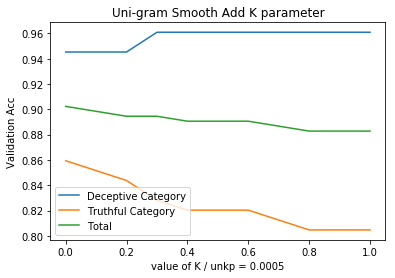

In [112]:
record = []
for k in range(11):
    record.append(validation_uni(uni_generator, 0.1 * k, 0.0005))

plt.plot(0.1 * np.arange(11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of K / unkp = 0.0005')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('Uni-gram Smooth Add K parameter')
plt.show()

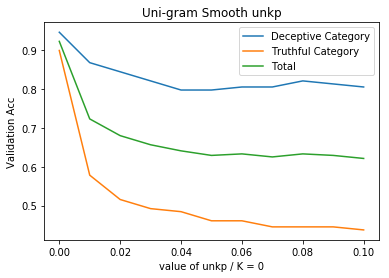

In [113]:
record = []
for unkp in range(11):
    record.append(validation_uni(uni_generator, 0, 0.01 * unkp))

plt.plot(0.01 * np.arange(11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of unkp / K = 0')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('Uni-gram Smooth unkp')
plt.show()

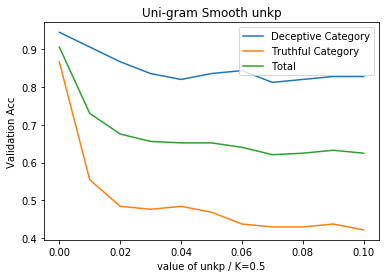

In [114]:
record = []
for unkp in range(11):
    record.append(validation_uni(uni_generator, 0.5, 0.01 * unkp))

plt.plot(0.01 * np.arange(11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of unkp / K=0.5')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('Uni-gram Smooth unkp')
plt.show()

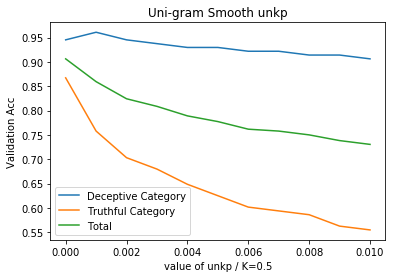

In [122]:
record = []
for unkp in range(11):
    record.append(validation_uni(uni_generator, 0.5, 0.001 * unkp))

plt.plot(0.001 * np.arange(11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of unkp / K=0.5')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('Uni-gram Smooth unkp')
plt.show()

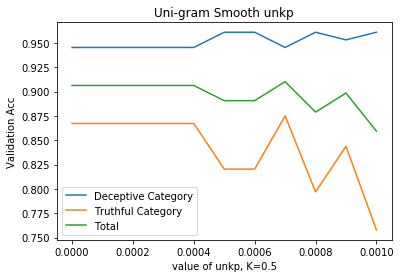

In [123]:
record = []
for unkp in range(11):
    record.append(validation_uni(uni_generator, 0.5, 0.0001 * unkp))

plt.plot(0.0001 * np.arange(11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of unkp, K=0.5')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('Uni-gram Smooth unkp')
plt.show()

In [40]:
validation_uni(uni_generator, 0.5, 0.0007)

[0.9453125, 0.875, 0.91015625]

In [125]:
# Bi LM parameter

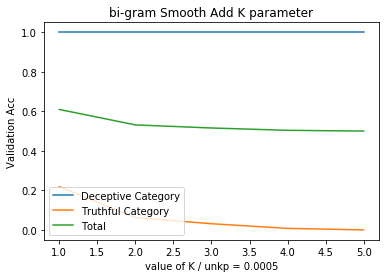

In [182]:
record = []
for k in range(1, 6):
    record.append(validation_bi(bi_generator, k, 0.0005))

plt.plot(np.arange(1, 6), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of K / unkp = 0.0005')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('bi-gram Smooth Add K parameter')
plt.show()

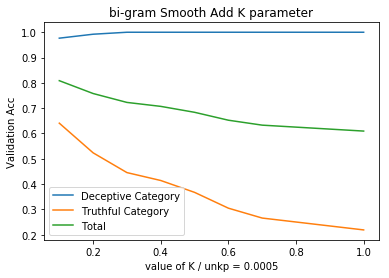

In [185]:
record = []
for k in range(1, 11):
    record.append(validation_bi(bi_generator, 0.1 * k, 0.0005))

plt.plot(0.1 * np.arange(1, 11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of K / unkp = 0.0005')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('bi-gram Smooth Add K parameter')
plt.show()

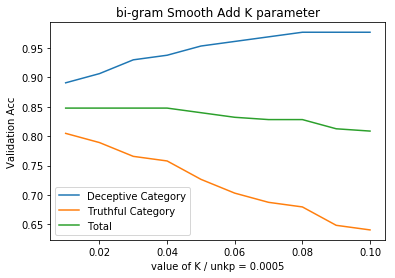

In [192]:
record = []
for k in range(1, 11):
    record.append(validation_bi(bi_generator, 0.01 * k, 0.0005))

plt.plot(0.01 * np.arange(1, 11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of K / unkp = 0.0005')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('bi-gram Smooth Add K parameter')
plt.show()

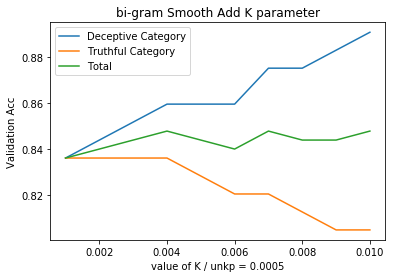

In [193]:
record = []
for k in range(1, 11):
    record.append(validation_bi(bi_generator, 0.001 * k, 0.0005))

plt.plot(0.001 * np.arange(1, 11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of K / unkp = 0.0005')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('bi-gram Smooth Add K parameter')
plt.show()

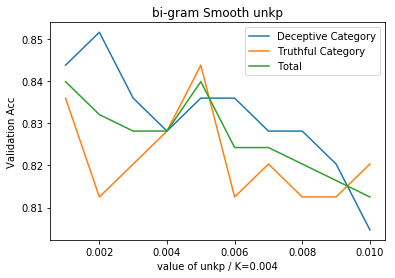

In [196]:
record = []
for unkp in range(1, 11):
    record.append(validation_bi(bi_generator, 0.004, 0.001 * unkp))

plt.plot(0.001 * np.arange(1, 11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of unkp / K=0.004')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('bi-gram Smooth unkp')
plt.show()

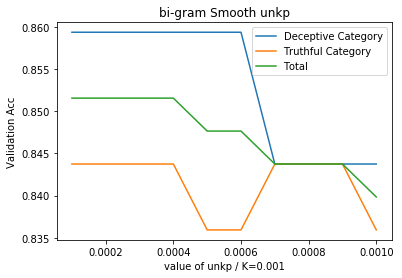

In [199]:
record = []
for unkp in range(1, 11):
    record.append(validation_bi(bi_generator, 0.004, 0.0001 * unkp))

plt.plot(0.0001 * np.arange(1, 11), record)
plt.ylabel('Validation Acc')
plt.xlabel('value of unkp / K=0.001')
plt.legend(('Deceptive Category', 'Truthful Category', 'Total'))
plt.title('bi-gram Smooth unkp')
plt.show()

In [41]:
validation_bi(bi_generator, 0.004, 0.0001)

[0.859375, 0.84375, 0.8515625]

In [209]:
def test_uni(uni_generator, k, unkp):
    prob_uni_d = uni_generator("deceptive", k, unkp)
    prob_uni_t = uni_generator("truthful", k, unkp)
    result = []
    f = open("./test/test.txt", "r")
    for idx, review in enumerate(f):
        words = review.split(" ")
        p_d = uni_predict(words, prob_uni_d)
        p_t = uni_predict(words, prob_uni_t)
        if p_d < p_t:
            result.append(str(1))
        else:
            result.append(str(0))
    return result

In [210]:
def test_bi(bi_generator, k, unkp):
    count_uni_d, count_bi_d  = bi_generator("deceptive", unkp)
    count_uni_t, count_bi_t = bi_generator("truthful", unkp)
    result = []
    f = open("./test/test.txt", "r")
    for idx, review in enumerate(f):
        words = review.split(" ")
        p_d = bi_predict(words, count_uni_d, count_bi_d, k)
        p_t = bi_predict(words, count_uni_t, count_bi_t, k)
        if p_d < p_t:
            result.append(str(1))
        else:
            result.append(str(0))
    return result


In [ ]:
uni_result = test_uni(uni_generator, 0.5, 0.0007)

In [ ]:
bi_result = test_bi(bi_generator, 0.004, 0.0001)

In [213]:
with open('prediction_LM_uni.csv','a') as file:
    file.write("Id,Prediction\n")
    for idx, val in enumerate(uni_result):
        file.write(",".join([str(idx), val]))
        file.write('\n')

In [214]:
with open('prediction_LM_bi.csv','a') as file:
    file.write("Id,Prediction\n")
    for idx, val in enumerate(bi_result):
        file.write(",".join([str(idx), val]))
        file.write('\n')